# 3.2 Support Vector Machine

Note: I took a good deal of help from this blog after quite a bit of troubleshooting: \
https://medium.com/@bedigunjit/simple-guide-to-text-classification-nlp-using-svm-and-naive-bayes-with-python-421db3a72d34

In [1]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import LinearSVC

np.random.seed(42)

In [2]:
df = pd.read_csv('./cleaned_data')
# dropping new rows with null selftext values
df.drop(df.loc[df['selftext'].isna()].index, inplace=True)
df.reset_index(drop=True, inplace=True)

X = df['selftext']
y = df['solotravel']

tvec = TfidfVectorizer()
tvec.fit(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=42)
X_train_transformed = tvec.transform(X_train)
X_test_transformed = tvec.transform(X_test)

In [3]:
def scores(model):
    print(f'train score: {model.score(X_train_transformed, y_train)}')
    print(f'test score: {model.score(X_test_transformed, y_test)}')
    print()
    
    try:
        print(f'best score: {model.best_score_}')
        print(f'best params: {model.best_params_}')
    except:
        pass

In [4]:
nb = MultinomialNB()

In [5]:
nb.fit(X_train_transformed, y_train)

MultinomialNB()

In [6]:
scores(nb)

train score: 0.779351087771943
test score: 0.7254313578394599



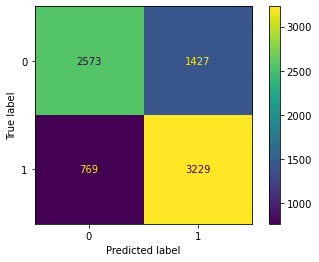

In [7]:
cm = confusion_matrix(y_test, nb.predict(X_test_transformed))
ConfusionMatrixDisplay(cm).plot();

Our train score has increased over the NB models but the test score has decreased, suggesting slight overfitting in the training and testing scores. On to the Support Vector Machine:

In [8]:
svm = LinearSVC(max_iter=5000, verbose=1)

In [9]:
svm.fit(X_train_transformed, y_train)

[LibLinear]

LinearSVC(max_iter=5000, verbose=1)

In [10]:
preds_svm_train = svm.predict(X_train_transformed)
accuracy_score(preds_svm_train, y_train)

0.8776881720430108

In [11]:
preds_svm_test = svm.predict(X_test_transformed)
accuracy_score(preds_svm_test, y_test)

0.7504376094023506

Here we saw the training score go up but the testing score stayed about the same, so now we have too much variance.

### Doing a grid search over different parameters for the SVM

In [12]:
svm = LinearSVC()
pgrid = {'C': np.linspace(0.0001, 1, 20)}
gcv = GridSearchCV(svm, pgrid, cv=5, n_jobs=-1, verbose=1)

In [13]:
%%time
gcv.fit(X_train_transformed, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
CPU times: user 731 ms, sys: 237 ms, total: 968 ms
Wall time: 23.2 s


GridSearchCV(cv=5, estimator=LinearSVC(), n_jobs=-1,
             param_grid={'C': array([1.00000000e-04, 5.27263158e-02, 1.05352632e-01, 1.57978947e-01,
       2.10605263e-01, 2.63231579e-01, 3.15857895e-01, 3.68484211e-01,
       4.21110526e-01, 4.73736842e-01, 5.26363158e-01, 5.78989474e-01,
       6.31615789e-01, 6.84242105e-01, 7.36868421e-01, 7.89494737e-01,
       8.42121053e-01, 8.94747368e-01, 9.47373684e-01, 1.00000000e+00])},
             verbose=1)

In [14]:
scores(gcv)

train score: 0.8169854963740936
test score: 0.7636909227306826

best score: 0.7627218587461965
best params: {'C': 0.10535263157894738}


We decreased the gap between our training and testing scores (with the best testing score yet of 76%), but the gap is still pretty significant at about 5% which still shows evidence of overfitting.